In [1]:
import os
import torch
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils_activations import rot13_alpha, LlamaActivationExtractor

In [2]:
load = True

In [3]:
# Define paths
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'
prompt_path = './prompts/three_hop_prompts.csv'

# Load prompt data
prompt_df = pd.read_csv(prompt_path)

In [4]:
if not load:
    # Initialize model and extractor
    activation_extractor = LlamaActivationExtractor(
        model_name_or_path=path,
        layer_defaults='even'
        )
    activation_extractor.overwrite_chat_template()

# Helper functions

In [5]:
from typing import Dict, List, Tuple


def logit_lens_single_layer(self, 
                           activation: torch.Tensor, 
                           apply_layer_norm: bool = True) -> torch.Tensor:
    """
    Apply logit lens to a single layer's activations.
    
    Args:
        activation: Tensor of shape (seq_len, hidden_dim) or (batch, seq_len, hidden_dim)
        apply_layer_norm: Whether to apply layer normalization before projection
        
    Returns:
        Logits tensor of shape (seq_len, vocab_size) or (batch, seq_len, vocab_size)
    """
    # Ensure activation is on the correct device
    activation = activation.to(self.device)
    
    # Apply layer normalization if requested (this is typically done in the final layer)
    if apply_layer_norm:
        activation = self.model.model.norm(activation)
    
    # Project to vocabulary space
    logits = self.model.lm_head(activation)

    return logits

def logit_lens_analysis(self, 
                       activations: Dict[str, torch.Tensor],
                       apply_layer_norm: bool = True,
                       top_k: int = 10) -> Dict[str, Dict]:
    """
    Perform logit lens analysis on extracted activations.
    
    Args:
        activations: Dictionary of layer activations
        apply_layer_norm: Whether to apply layer normalization before projection
        top_k: Number of top predictions to return for each position
        
    Returns:
        Dictionary containing logit lens results for each layer
    """
    results = {}
    
    for layer_name, activation in activations.items():
        # Get logits for this layer
        logits = logit_lens_single_layer(self, activation, apply_layer_norm)
        
        # Get probabilities
        probs = F.softmax(logits, dim=-1)
        
        # Get top-k predictions for each position
        top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
        
        # Convert to tokens
        seq_len = logits.shape[-2]
        position_predictions = []
        
        for pos in range(seq_len):
            pos_top_k_indices = top_k_indices[pos] if logits.dim() == 2 else top_k_indices[0, pos]
            pos_top_k_probs = top_k_probs[pos] if logits.dim() == 2 else top_k_probs[0, pos]
            
            predictions = []
            for i in range(top_k):
                token_id = pos_top_k_indices[i].item()
                prob = pos_top_k_probs[i].item()
                token = self.tokenizer.decode([token_id])
                predictions.append({
                    'token': token,
                    'token_id': token_id,
                    'probability': prob
                })
            
            position_predictions.append(predictions)
        
        results[layer_name] = {
            'logits': logits.cpu(),
            'probabilities': probs.cpu(),
            'top_k_predictions': position_predictions
        }
    
    return results

def compare_logit_lens_predictions(self, 
                                 logit_lens_results: Dict[str, Dict],
                                 actual_tokens: List[str],
                                 position: int = -1) -> Dict:
    """
    Compare logit lens predictions across layers for a specific position.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        actual_tokens: List of actual tokens generated
        position: Position to analyze (-1 for last position)
        
    Returns:
        Dictionary comparing predictions across layers
    """
    if position == -1:
        position = len(actual_tokens) - 1
    
    comparison = {
        'position': position,
        'actual_token': actual_tokens[position] if position < len(actual_tokens) else None,
        'layer_predictions': {}
    }
    
    for layer_name, results in logit_lens_results.items():
        if position < len(results['top_k_predictions']):
            comparison['layer_predictions'][layer_name] = results['top_k_predictions'][position]
    
    return comparison

def get_logit_lens_evolution(self, 
                                 logit_lens_results: Dict[str, Dict],
                                 target_token: str,
                                 position: int = -1,
                                 ) -> plt.Figure:
    """
    Visualize how the probability of a target token evolves across layers.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        target_token: Token to track across layers
        position: Position to analyze (-1 for last position)
        figsize: Figure size for the plot
        
    Returns:
        matplotlib Figure object
    """
    # Extract layer numbers and probabilities
    layer_nums = []
    probabilities = []
    
    for layer_name, results in logit_lens_results.items():
        # Extract layer number from layer name (assumes format "layer_X")
        layer_num = int(layer_name.split('_')[-1])
        layer_nums.append(layer_num)
        
        # Find probability of target token at specified position
        if position == -1:
            position = len(results['top_k_predictions']) - 1
        
        target_prob = 0.0
        if position < len(results['top_k_predictions']):
            for pred in results['top_k_predictions'][position]:
                if pred['token'] == target_token:
                    target_prob = pred['probability']
                    break
        
        probabilities.append(target_prob)
    
    # Sort by layer number
    sorted_data = sorted(zip(layer_nums, probabilities))
    layer_nums, probabilities = zip(*sorted_data)
    return layer_nums, probabilities

def visualize_logit_lens_evolution(self, 
                                 logit_lens_results: Dict[str, Dict],
                                 target_token: str,
                                 position: int = -1,
                                 figsize: Tuple[int, int] = (12, 8)) -> plt.Figure:
    """
    Visualize how the probability of a target token evolves across layers.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        target_token: Token to track across layers
        position: Position to analyze (-1 for last position)
        figsize: Figure size for the plot
        
    Returns:
        matplotlib Figure object
    """
    # Extract layer numbers and probabilities
    layer_nums = []
    probabilities = []
    
    for layer_name, results in logit_lens_results.items():
        # Extract layer number from layer name (assumes format "layer_X")
        layer_num = int(layer_name.split('_')[-1])
        layer_nums.append(layer_num)
        
        # Find probability of target token at specified position
        if position == -1:
            position = len(results['top_k_predictions']) - 1
        
        target_prob = 0.0
        if position < len(results['top_k_predictions']):
            for pred in results['top_k_predictions'][position]:
                if pred['token'] == target_token:
                    target_prob = pred['probability']
                    break
        
        probabilities.append(target_prob)
    
    # Sort by layer number
    sorted_data = sorted(zip(layer_nums, probabilities))
    layer_nums, probabilities = zip(*sorted_data)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(layer_nums, probabilities, 'b-o', linewidth=2, markersize=6)
    ax.set_xlabel('Layer Number')
    ax.set_ylabel('Probability')
    ax.set_title(f'Probability Evolution of Token "{target_token}" at Position {position}')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(probabilities) * 1.1 if probabilities else 1)
    
    return fig

def analyze_prediction_confidence(self, 
                                logit_lens_results: Dict[str, Dict],
                                position: int = -1) -> Dict:
    """
    Analyze prediction confidence across layers using entropy and top-1 probability.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        position: Position to analyze (-1 for last position)
        
    Returns:
        Dictionary with confidence metrics for each layer
    """
    confidence_metrics = {}
    
    for layer_name, results in logit_lens_results.items():
        if position == -1:
            pos = len(results['top_k_predictions']) - 1
        else:
            pos = position
        
        if pos < len(results['top_k_predictions']):
            # Get full probability distribution for this position
            probs = results['probabilities'][pos] if results['probabilities'].dim() == 2 else results['probabilities'][0, pos]
            
            # Calculate entropy (lower = more confident)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10)).item()
            
            # Get top-1 probability
            top1_prob = results['top_k_predictions'][pos][0]['probability']
            
            # Get top-1 token
            top1_token = results['top_k_predictions'][pos][0]['token']
            
            confidence_metrics[layer_name] = {
                'entropy': entropy,
                'top1_probability': top1_prob,
                'top1_token': top1_token,
                'position': pos
            }
    
    return confidence_metrics

def get_layer_names(self) -> List[str]:
    """Get all available layer names in the model."""
    return [name for name, _ in self.model.named_modules()]

In [6]:
def align_tokens(short_tokens, long_tokens):
    """
    Align two different tokenizations of the same text.

    Args:
        short_tokens: List of tokens from fine-grained tokenization
        long_tokens: List of tokens from coarse-grained tokenization

    Returns:
        alignment: List where alignment[i] gives the long_token index 
                  that short_tokens[i] belongs to
    """
    # Reconstruct the original text to verify consistency
    short_text = ''.join(short_tokens)
    long_text = ''.join(long_tokens)

    if short_text != long_text:
        raise ValueError("Token sequences don't represent the same text")

    alignment = []
    short_pos = 0  # Character position in short tokenization
    long_pos = 0   # Character position in long tokenization
    long_idx = 0   # Current index in long_tokens

    for short_idx, short_token in enumerate(short_tokens):
        # Track how much of the short token has been aligned
        remaining_short_token = short_token

        while remaining_short_token:
            if long_idx >= len(long_tokens):
                raise ValueError(f"Could not align short token {short_idx}: '{short_token}'")

            long_token = long_tokens[long_idx]
            long_token_remaining = long_token[long_pos - sum(len(t) for t in long_tokens[:long_idx]):]

            if remaining_short_token.startswith(long_token_remaining):
                # Fully consume the current long token
                alignment.append(long_idx)
                remaining_short_token = remaining_short_token[len(long_token_remaining):]
                long_idx += 1
                long_pos += len(long_token_remaining)
            elif long_token_remaining.startswith(remaining_short_token):
                # Fully consume the current short token
                alignment.append(long_idx)
                long_pos += len(remaining_short_token)
                remaining_short_token = ''
            else:
                raise ValueError(f"Could not align short token {short_idx}: '{short_token}'")

    return alignment

# Gather results

In [7]:
pickle_path = 'pickles/3b.pkl'

In [8]:
if load:
    with open(pickle_path, 'rb') as f:
        all_results = pickle.load(f)
else:
    # Iterate over all prompts and extract data
    all_results = {'prob': [], 'layer': []}

    for idx in range(len(prompt_df)):
        concept = 'person'
        person = prompt_df.iloc[idx]['Person']
        state = prompt_df.iloc[idx]['State']
        reasoning_question = prompt_df.iloc[idx]['Prompt']

        # Generate response
        formatted = activation_extractor.tokenizer.apply_chat_template(
            [{'role': 'user', 'content': reasoning_question}],
            tokenize=False,
            add_generation_prompt=True,
        )
        generation_results = activation_extractor.generate_with_activations(
            formatted,
            do_sample=False,
            max_new_tokens=1000,
            temperature=0.0,
        )

        # Process tokens
        end_think_idx = np.argwhere(np.array(generation_results['response_tokens']) == "</think>")
        if end_think_idx.size != 0:
            end_think_idx = end_think_idx.item()
        else:
            end_think_idx = len(generation_results['response_tokens'])
        response_tokens = generation_results['response_tokens'][:end_think_idx]
        merged_response = ''.join(response_tokens)
        translated_response_tokens = [rot13_alpha(t) for t in response_tokens]

        english_token_ids = activation_extractor.tokenizer.encode(rot13_alpha(merged_response), add_special_tokens=False)
        english_tokens = [activation_extractor.tokenizer.decode(e) for e in english_token_ids]

        word_start_idxs = [idx for idx, token in enumerate(translated_response_tokens) if token.startswith(' ')]
        token_alignments = align_tokens(translated_response_tokens, english_tokens)

        # Logit lens analysis
        logit_lens_results = logit_lens_analysis(
            activation_extractor,
            generation_results['token_activations'],
            top_k=5
        )

        # Collect results
        for word_start_idx in word_start_idxs:
            target_token = english_tokens[token_alignments[word_start_idx]]
            layers, probs = get_logit_lens_evolution(
                activation_extractor, 
                logit_lens_results,
                target_token=target_token,
                position=word_start_idx
            )
            all_results['prob'].extend(probs)
            all_results['layer'].extend(layers)
    with open(pickle_path, 'wb') as f:
        pickle.dump(all_results, f)

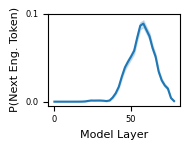

In [11]:
# Plot averaged results
df = pd.DataFrame(all_results)
fig, ax = plt.subplots(figsize=(2., 1.6))
sns.lineplot(data=df, x='layer', y='prob', ax=ax)
plt.ylabel('P(Next Eng. Token)', fontsize=8)
plt.xlabel('Model Layer', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks([0, 0.1], fontsize=6)
plt.tight_layout()
plt.savefig('figures/3b.png', dpi=300, transparent=True)
plt.show()

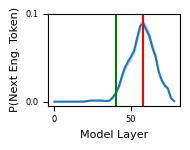

In [10]:
# Plot averaged results
df = pd.DataFrame(all_results)
fig, ax = plt.subplots(figsize=(2., 1.6))
sns.lineplot(data=df, x='layer', y='prob', ax=ax)
plt.ylabel('P(Next Eng. Token)', fontsize=8)
plt.xlabel('Model Layer', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks([0, 0.1], fontsize=6)
plt.tight_layout()
plt.axvline(58, color='red')
plt.axvline(40, color='green')
plt.show()